# Laboratorio No. 4
- Ricardo Méndez 21289
- Sara Echeverría 21371
- Francisco Castillo 21562
- Melissa Pérez 21385

Enlace al repositorio: [https://github.com/bl33h/bankCustomerSegmentation]

# Task 1

### ¿Qué son los grafos computacionales? y ¿cuál es su importancia para el cálculo de gradientes en aplicaciones como backpropagation?
Los grafos computacionales son una representación visual y matemática donde sus nodos corresponden a una operación y los arcos los valores de entrada/salida. Se usan comúnmente para descibir algoritmos y modelos de aprendizaje automático. En el cálculo de gradientes toman un papel importante porque proporcionan una representación clara y estructurada de las operaciones. Lo cual ayuda a que las conexiones entre nodos representen el flujo de datos entre las operaciones. Además, los grafos computacionales permiten realizar el cálculo de los gradientes de forma óptima, lo que ayuda a entrenar modelos por medio de algoritmos.

[Understanding Gradient Descent and Backpropagation](https://www.shramos.com/2019/02/understanding-gradient-descent-and_3.html)

### Detalle cuales son los componentes y pasos que conforman una red neuronal. Con esto en mente, ¿cómo mejoraría el perceptrón que hizo en el laboratorio pasado?
### Componentes
- Input (imágenes, datos, etc)
- Input layer
- Output layer
- Hidden layers
- Cada una de estas tienen un bias, es decir, un valor numérico asociado
- Conexiones entre capas llamadas canales, estas cuentan con pesos
- Funciones de activación, las cuales ayudan a determinar si un valor de una neurona pasa a la siguiente capa.

### Pasos que conforman una red neuronal
- Inicialización: Se establecen los pesos y los sesgos con valores pequeños aleatorios.
- Forward propagation:  Calcula la salida de la red para un conjunto de entradas, pasando los valores a través de las capas de la red y aplicando funciones de activación.
- Activación: Determina la salida de las neuronas. El perceptrón utiliza una función de paso, pero las redes neuronales más complejas pueden usar elementos más sofisticados como ReLu.
- Cálculo de error: Se calcula la diferencia entre la salida esperada y la salida obtenida de la red.
- Backpropagation: Ajusta los pesos y sesgos de la red para minimizar el error, utilizando el gradiente del error respecto a cada peso y sesgo. Siendo sus pasos:
    - Calcular el error
    - Aplicar el algoritmo de gradiente descendiente
        - Este algoritmo irá calculando la derivada de una función en cada punto donde se encuentre y luego irá moviéndose en dirección a donde la derivada se reduzca
    - Actualizar los pesos
    - Actualizar los bias
- Optimización: Actualiza los pesos y sesgos para minimizar la función de costo.

### Tomando en consideración lo anteriormente mencionado, se sugieren las siguientes mejoras para el perceptrón del Laboratorio No. 3:
- Mejorar la activación: La función de paso unitario limita la capacidad del modelo para realizar ajustes finos durante el entrenamiento. Usar una función de activación como la sigmoid para permitir gradaciones en la clasificación podría mejorar la precisión.
- Regularización: Aplicar una técnica para prevenir el sobreajuste del modelo.
- Optimización de hiperparámetros: El código utiliza valores fijos para la tasa de aprendizaje y el número de iteraciones. Utilizar técnicas de búsqueda de hiperparámetros, como la validación cruzada, podría encontrar valores que mejoren el rendimiento del modelo.
- Scalating: Estandarizar las características de entrada para que tengan la misma escala para acelerar la convergencia.
- Inicializar los pesos utilizando una estrategia: La inicialización de He o Glorot, podría contribuir a una convergencia más rápida y efectiva, dándole un enfoque más sofisticado al modelo.
- Utilizar otras métricas de evaluación como complemento: Además de la accuracy, considerar métricas como la curva ROC o el área bajo la curva (AUC) para tener una visión más completa del rendimiento del modelo en tareas de clasificación binaria.

![pic](media/pic.png)

(Artificial Intelligence: Principles and Techniques Ke Yuan - Machine Learning & Artificial Intelligence MLAI4DS - University of Glasgow; IBM documentation, n.d.)

### ¿Cómo se selecciona el valor K usando el método de la silueta para el algoritmo de K-Means. Explique las fórmulas (ecuaciones) que lo componen así como las asumpciones, si hay.

La aplicación del algoritmo al dataset conlleva su utilización múltiples veces, variando el valor de K, que representa el número de clústeres.

### Cálculo de la silueta para cada punto
- a (i) La distancia media entre un punto ‘i’ y todos los demás puntos en el mismo clúster.
- b (i) La distancia media mínima de ‘i’ a todos los puntos en otro clúster, de tal manera que ‘i’  no es miembro de ese clúster. Esta distancia se mide para el clúster más cercano al punto.

###  Ecuación del coeficiente de silueta para un punto

![pic2](media/pic2.png)

###  Cálculo promedio de la silueta para cada valor de ‘K’
Se calcula el promedio del coeficiente de silueta para todos los puntos en dataset para cada valor de K, este brinda qué tan apropiadamente se han agrupado los datos en clústeres.

###  ¿Cómo se interpreta el valor óptimo para ‘K’?
El valor óptimo maximiza el promedio del coeficiente de silueta sobre todos los valores de K considerados, por lo que un valor alto indica un mejor ajuste entre los puntos dentro de los clústeres y una mayor separación entre estos.

###  Consideraciones
- Se asume que los clústeres son separables y bien definidos en el espacio de los features, si estos se traslapan significativamente, el método de la silueta podría no ser eficaz.
- Este método se basa en el cálculo de distancias (usualmente distancia euclidiana) entre puntos en el espacio de features, por lo que se asume que el espacio es métrico y que las distancias son un buen indicador de la similitud entre puntos.
- Se recomienda normalizar los datos antes de aplicar K-Means, especialmente si las características del dataframe tienen escalas muy diferentes. Esto asegura que todas la contribución equitativamente de las columnas de interés al cálculo de las distancias.
- La elección del valor de ‘K’ también debería considerar el conocimiento del dominio y las limitaciones computacionales, especialmente para conjuntos de datos muy grandes.

(Mahendru, 2021; What is the relation between k-means clustering and PCA?, n.d.)

### Investigue sobre Principal Component Analysis (PCA) y responda respecto a algoritmos como K-Means ¿Cómo podría ayudarle a mejorar la calidad de sus clusters cuando se usa K-Means?

En términos generales, (PCA) es una técnica de reducción de dimensionalidad utilizada para disminuir la cantidad de variables en un dataframe, manteniendo al mismo tiempo la mayor cantidad de información posible. 

Este método podría ayudar a mejorar la calidad de los clústers si se utiliza K-Means, al mantener los features que aportan más a la variación en el conjunto de datos. Esto ya que al aplicar K-Means con características reducidas, es posible mitigar o reducir el efecto de la dimensionalidad, obteniendo clústeres más significativos. De igual manera, puede facilitar su visualización e interpretación.

Otro aspecto relevante sería que los cálculos para determinar la distancia entre los puntos y los centroides serían más rápidos y eficientes, pues se contaría con menos dimensiones. Asimismo se minimiza el ruido,  al ignorar las componentes con varianzas bajas y se resaltan las estructuras subyacentes en los datos, dando como resultado la formación de clústeres más cohesivos, separados y datos más estables.

### Consideraciones
- Es crucial elegir adecuadamente el número de componentes principales a retener, pues se pueden presentar los escenarios extremos de pérdida de información importante para los clústeres y/o presencia de dimensionalidad.
- PCA es sensible a la escala de variables, por lo que es pertinente estandarizar los datos para asegurar que cada característica contribuya equitativamente al análisis.

(Jha, 2021)

### Referencias 
- CS221: Artificial Intelligence: Principles and Techniques Ke Yuan - Machine Learning & Artificial Intelligence MLAI4DS - University of Glasgow
- IBM documentation. (n.d.). https://www.ibm.com/docs/en/spss-modeler/18.0.0?topic=networks-neural-model
- Jha. (2021). Implementation of Principal Component Analysis(PCA) in K means clustering. Medium. https://medium.com/analytics-vidhya/implementation-of-principal-component-analysis-pca-in-k-means-clustering-b4bc0aa79cb6
- Mahendru. (2021). How to determine the optimal K for K-Means? - Analytics Vidhya - Medium. Medium. https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb
- What is the relation between k-means clustering and PCA? (n.d.). Cross Validated. https://stats.stackexchange.com/questions/183236/what-is-the-relation-between-k-means-clustering-and-pca#:~:text=K-means%20is%20a%20least,least-squares%20cluster%20membership%20vector.

# Análisis exploratorio

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

plt.style.use('ggplot')

C:\Users\euroc\AppData\Local\Temp\ipykernel_1492\3314469405.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('data/bank_transactions.csv')
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [53]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB
None


In [54]:
print(df.describe())

       CustAccountBalance  TransactionTime  TransactionAmount (INR)
count        1.046198e+06     1.048567e+06             1.048567e+06
mean         1.154035e+05     1.570875e+05             1.574335e+03
std          8.464854e+05     5.126185e+04             6.574743e+03
min          0.000000e+00     0.000000e+00             0.000000e+00
25%          4.721760e+03     1.240300e+05             1.610000e+02
50%          1.679218e+04     1.642260e+05             4.590300e+02
75%          5.765736e+04     2.000100e+05             1.200000e+03
max          1.150355e+08     2.359590e+05             1.560035e+06


In [3]:
# relevant columns in the dataframe
selected_features = [
    'CustomerDOB',  # To get the age of the customer
    'CustGender',  # To get the gender
    'CustAccountBalance',  # To get the account balance
    'TransactionAmount (INR)',  # To get the amount of the transaction in rupees
]

features = df[selected_features]

In [4]:
# check for missing values
features.isnull().sum()

CustomerDOB                3397
CustGender                 1100
CustAccountBalance         2369
TransactionAmount (INR)       0
dtype: int64

In [5]:
# Remove missing values
features = features.dropna()

In [6]:
features.count()

CustomerDOB                1041765
CustGender                 1041765
CustAccountBalance         1041765
TransactionAmount (INR)    1041765
dtype: int64

### Encoding y transformación de valores

In [7]:
# categorical features and change other values to its numerical representation
features['CustGender'] = features['CustGender'].map({'F': 1, 'M': 0})  # 1 for female and 0 for male

# rename column
features.rename(
    columns={
        'CustGender': 'Female?',
        'CustAccountBalance': 'Balance',
        'TransactionAmount (INR)': 'Amount',
    },
    inplace=True)

In [8]:
features = features.dropna()
features.count()

CustomerDOB    1041764
Female?        1041764
Balance        1041764
Amount         1041764
dtype: int64

In [9]:
features["CustomerDOB"] = pd.to_datetime(features["CustomerDOB"])

C:\Users\euroc\AppData\Local\Temp\ipykernel_1492\1050743629.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  features["CustomerDOB"] = pd.to_datetime(features["CustomerDOB"])


In [10]:
# Get the Customer age
features = features.drop(features[features['CustomerDOB'] == '1/1/1800'].index, axis=0)
features.loc[features.CustomerDOB.dt.year >= 2022, 'CustomerDOB'] = features.loc[features.CustomerDOB.dt.year >= 2022, 'CustomerDOB'] - pd.DateOffset(years=100)
features['CustomerAge'] = ((pd.to_datetime('today') - features['CustomerDOB']).dt.days / 365.25).round(0)

In [63]:
features.head()

,CustomerDOB,Female?,Balance,Amount,CustomerAge
0,1994-10-01,1.0,17819.05,25.0,29.0
1,1957-04-04,0.0,2270.69,27999.0,67.0
2,1996-11-26,1.0,17874.44,459.0,27.0
3,1973-09-14,1.0,866503.21,2060.0,50.0
4,1988-03-24,1.0,6714.43,1762.5,36.0


In [11]:
# Drop NaN values
features = features.dropna()

# Drop the CustomerDOB column
features = features.drop('CustomerDOB', axis=1)

In [65]:
features.head()

,Female?,Balance,Amount,CustomerAge
0,1.0,17819.05,25.0,29.0
1,0.0,2270.69,27999.0,67.0
2,1.0,17874.44,459.0,27.0
3,1.0,866503.21,2060.0,50.0
4,1.0,6714.43,1762.5,36.0


In [66]:
features.describe()

,Female?,Balance,Amount,CustomerAge
count,985473.000000,9.854730e+05,9.854730e+05,985473.000000
mean,0.276922,1.060590e+05,1.452449e+03,38.653658
std,0.447478,8.178443e+05,6.139422e+03,8.763662
min,0.000000,0.000000e+00,0.000000e+00,3.000000
25%,0.000000,4.581130e+03,1.510000e+02,33.000000
50%,0.000000,1.600759e+04,4.310000e+02,36.000000
75%,1.000000,5.375908e+04,1.125000e+03,42.000000
max,1.000000,1.150355e+08,1.560035e+06,101.000000


### Balanceo de clases

En este caso la variable de interés 'CustGender' sí está desbalanceada, por lo que es pertinente aplicar una técnica para corregirlo.

In [12]:
features['Female?'].value_counts()

Female?
0.0    712574
1.0    272899
Name: count, dtype: int64

In [13]:
male = features[features['Female?'] == 0]
female = features[features['Female?'] == 1]
male = male.sample(n=len(female), random_state=7)
features = pd.concat([male, female])

In [14]:
features['Female?'].value_counts()

Female?
0.0    272899
1.0    272899
Name: count, dtype: int64

### Scaling
Las magnitudes de los datos varían significativamente, por lo que es necesario escalar los valores de 'TransactionTimeSeconds' y 'TransactionAmount (INR)'.

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [16]:
# Create a copy of the dataframe with scaled features (for it to be used for clustering, classify, then analyze the data with the original features)
scaled_features = features.copy()

# Scale the features
to_scale = ['Amount', 'CustomerAge', 'Balance']

# Scale the features
scaled_features[to_scale] = scaler.fit_transform(scaled_features[to_scale])

# Show the scaled features
scaled_features.head()

,Female?,Balance,Amount,CustomerAge
974270,0.0,-0.107183,-0.238270,0.169393
622443,0.0,-0.113533,-0.179216,0.508833
4768,0.0,-0.086650,-0.135219,-0.622633
37123,0.0,-0.116716,0.118060,0.508833
185587,0.0,-0.127482,-0.127022,0.282539


### Feature selection
Debido a la naturaleza del objetivo para este dataframe, el cual es segmentar a clientes de una entidad bancaria para poder así tomar decisiones a nivel comercial y
potenciar las operaciones de la empresa. Los features considerados de utilidad son:
- 'Female?': para identificar el género del cliente (1 para mujer, 0 para hombre)
- 'Amount': para identificar el monto de la transacción realizada por el cliente
- 'CustomerAge': para identificar la edad del cliente
- 'Balance': para identificar el valor de la cuenta del cliente

En términos generales, las variables del dataframe no se encontraban en óptimas condiciones para la implementación del modelo no supervisado, por lo que se realizaron acciones como encoding, scaling y balanceo de clases. Los features expuestos anteriormente representan temas de interés para una entidad bancaria, ya que con estos es posible la identificación de grupos de clientela, permitiendo la visualización de alguna correlación entre el género, el monto de las transacciones realizadas por el cliente, el valor de la cuenta, entre otros. Por dicha razón, se seleccionaron los features indicadas.

# Task 2.1 K-Means

## ¿Es necesario hacer un split del dataset? ¿Por qué?
No, el objetivo de hacer un split de los datos es el poder evaluar el desempeño del modelo. Al ser no supervisado, el hacer esto puede ser contraproducente, ya que no se cuenta con un target para evaluar el desempeño del modelo. Por lo que se puede utilizar el dataset completo para el entrenamiento del modelo.

## Selección del número de clusters

In [22]:
from sklearn.cluster import KMeans

In [23]:
# List to save the inertia for each number of clusters
inertia_values = []

# Range of cluster numbers to check
cluster_range = range(2, 11)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=7)
    kmeans.fit(scaled_features)
    inertia_values.append(kmeans.inertia_)

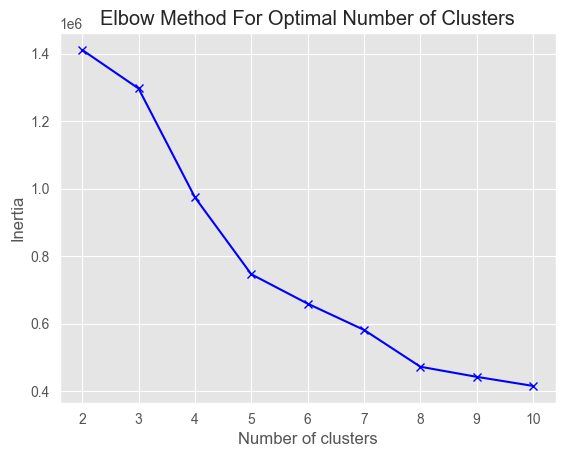

In [24]:
# Plotting the inertia values
plt.plot(cluster_range, inertia_values, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()

El número ideal de clusters es de 5.

## Modelo sin Librerías

In [21]:
def get_euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))


class KMeansScratch:
    # Reference: https://www.youtube.com/watch?v=6UF5Ysk_2gk
    def __init__(self, K=5, max_iterations=100):
        self.K = K
        self.max_iterations = max_iterations

        # Each list contains the samples indices for the respective cluster
        self.clusters = [[] for _ in range(self.K)]

        # the centers (mean feature vector) for each cluster
        self.centroids = []

    def predict(self, X: pd.DataFrame):
        self.X = X
        self.n_samples, self.n_features = X.shape

        # Get random samples to be the initial centroids
        random_samples_ids = np.random.choice(self.n_samples, self.K, replace=False)
        self.centroids = [self.X.iloc[id] for id in random_samples_ids]

        # Optimize clusters
        for _ in range(self.max_iterations):
            # Assign samples to the closest centroids to create clusters
            self.clusters = self._create_clusters(self.centroids)

            # Calculate new centroids from the clusters
            old_centroids = self.centroids
            self.centroids = self._get_centroids(self.clusters)

            # Check if clusters have changed
            if self._has_converged(old_centroids, self.centroids):
                break

        # Classify samples as the index of their clusters
        return self._get_cluster_labels(self.clusters)

    def _create_clusters(self, centroids: list):
        clusters = [[] for _ in range(self.K)]

        for id, sample in enumerate(self.X.values):
            # Get the closest centroid for the sample
            centroid_id = self._closest_centroid(sample, centroids)
            clusters[centroid_id].append(id)

        return clusters

    def _closest_centroid(self, sample, centroids):
        distances = [get_euclidean_distance(sample, point) for point in centroids]
        closest_id = np.argmin(distances)

        return closest_id

    def _get_centroids(self, clusters: list):
        centroids = np.zeros((self.K, self.n_features))
        for cluster_id, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.X.iloc[cluster], axis=0)
            centroids[cluster_id] = cluster_mean
        return centroids

    def _has_converged(self, old_centroids: list, centroids: list):
        distances = [get_euclidean_distance(old_centroids[i], centroids[i]) for i in range(self.K)]
        return sum(distances) == 0

    def _get_cluster_labels(self, clusters: list):
        labels = np.empty(self.n_samples)

        for cluster_id, cluster in enumerate(clusters):
            for sample_id in cluster:
                labels[sample_id] = cluster_id

        return labels


In [22]:
kmeans_scratch = KMeansScratch()

predicted_clusters = kmeans_scratch.predict(scaled_features)

KeyboardInterrupt: 

### Visualización de los Clusters generados

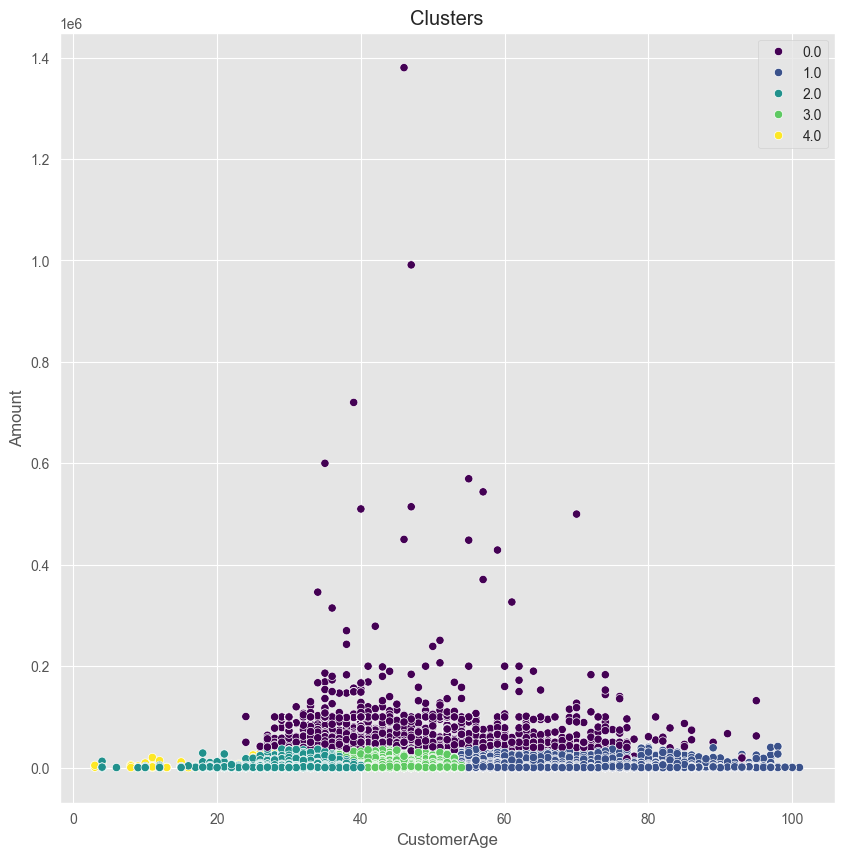

In [27]:
# Plot the clusters
plt.figure(figsize=(10, 10))
sns.scatterplot(x='CustomerAge', y='Amount', data=features, hue=predicted_clusters, palette='viridis')
plt.title('Clusters')
plt.show()

### Evaluación del modelo

In [18]:
# Silhouette score
from sklearn.metrics import silhouette_score

silhouette_score(scaled_features, predicted_clusters)

NameError: name 'predicted_clusters' is not defined

El modelo tiene un silhouette score de 0.42, lo que indica que los clusters están parcialmente definidos; parcialmente debido a que, cómo puede observarse en la parte superior, la distribución de los datos no permite que los clusters sean tan precisos. Sin embargo, nos da una idea de como pueden estar agrupados los clientes. Esta métrica fue seleccionada, ya que es una medida de cuán similar es un punto a su propio cluster (cohesión) en comparación con otros clusters (separación). El valor de la métrica es entre -1 y 1, donde un valor cercano a 1 indica que el punto está bien clasificado.

## Modelo con librerías

In [41]:
kmeans = KMeans(n_clusters=5, random_state=7)
pred_y = kmeans.fit_predict(scaled_features)

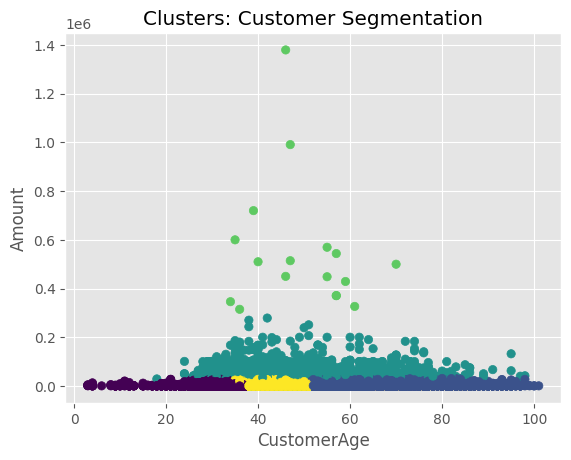

In [74]:
plt.scatter(x='CustomerAge', y='Amount', data=features, c=pred_y)
plt.xlabel('CustomerAge')
plt.ylabel('Amount')
plt.title('Clusters: Customer Segmentation')
plt.show()

In [44]:
score = silhouette_score(scaled_features, pred_y)
print('Silhouette Score: ', score)

Silhouette Score:  0.5337491684335006


Esta implementación devuelve una métrica de desempeño de 0.53, lo cual es aceptable ya que el Silhouette Score busca valores entre -1 y 1. Un valor cercano a 1 indica que las muestras están bien agrupadas en sus propios cluster y lejos de otros. En este caso, por el valor obtenido, al ser una puntuación ligeramente por encima de 0.5 puede considerarse bastante buena conociendo la distribución de los features seleccionados.

### Comparación de resultados
La mejor la implementación del modelo fue la realizada con librerías debido a que brindó una métrica de desempeño más cercana al agrupamiento deseado. Esto se debe a que al utilizar las librerías de aprendizaje automático de python nos brindan mayor optimización y funcionalidades en los distintos grupos de datos.

# Task 2.2 Mixture Models

### ¿Podría PCA ayudarle a mejorar sus clusters? ¿Por qué?
Sí, el Análisis de Componentes Principales puede mejorar los clusters porque se reduce la dimencionalidad de los datos que favorece en la distancia entre los pares de puntos. Además, para la visualización de datos se vería beneficioso en su dispersión.

## Modelo sin librerías

In [42]:
n_components = 5
n_samples, n_features = scaled_features.shape

pi = np.ones((n_components)) / n_components
means = np.random.choice(n_samples, n_components)
variances = np.random.random_sample(size=n_components)



In [43]:
n_samples, n_features = scaled_features.shape
weights = np.zeros((n_components,n_samples))

def step_expectation(samples,n_components,means):
    weights = np.zeros((n_components,samples))
    for i in range(n_components):   
        weights[i,:] = np.linalg.norm(scaled_features - means[i], axis=1)
    return weights


In [44]:
def step_maximization( weights, n_components, pi, means, variances):
    r = []
    for j in range(n_components):  
        r.append((weights[j] * pi[j]) / (np.sum([weights[i] * pi[i] for i in range(n_components)], axis=0)))

        means[j] = np.sum(r[j] * scaled_features) / (np.sum(r[j]))
        variances[j] = np.sum(r[j] * np.square(scaled_features - means[j])) / (np.sum(r[j]))
        
        pi[j] = np.mean(r[j])
    return variances,means,pi

In [45]:
n_steps = 20
for step in range(n_steps):
    weights = step_expectation(n_samples,n_components,means)
    variances,means,pi = step_maximization(weights, n_components, pi, means, variances)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\euroc\Desktop\U\IA\IA-Phising-Website-Detection\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\euroc\AppData\Local\Temp\ipykernel_1492\201277883.py", line 4, in <module>
    variances,means,pi = step_maximization(weights, n_components, pi, means, variances)
  File "C:\Users\euroc\AppData\Local\Temp\ipykernel_1492\2641185995.py", line 6, in step_maximization
    means[j] = np.sum(r[j] * scaled_features) / (np.sum(r[j]))
  File "c:\Users\euroc\Desktop\U\IA\IA-Phising-Website-Detection\.venv\lib\site-packages\pandas\core\generic.py", line 2168, in __array_ufunc__
    return arraylike.array_ufunc(self, ufunc, method, *inputs, **kwargs)
  File "c:\Users\euroc\Desktop\U\IA\IA-Phising-Website-Detection\.venv\lib\site-packages\pandas\core\arraylike.py", line 276, in array_ufunc
    result = maybe_dispatch_ufunc_to_dunder_op(self, ufunc, m

## Modelo con librerías

In [105]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

bic = []
n_components_range = range(2, 11)
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=7)
    gmm.fit(scaled_features)
    bic.append(gmm.bic(scaled_features))

# Graficar la curva del codo (BIC)
plt.plot(n_components_range, bic, marker='o')
plt.title('Curva del codo para GMM')
plt.xlabel('Número de componentes')
plt.ylabel('BIC')
plt.xticks(n_components_range)
plt.show()

KeyboardInterrupt: 

In [83]:
gmm = GaussianMixture(n_components=5, random_state=7)
gmm.fit(scaled_features)
y_gmm = gmm.predict(scaled_features)

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import chi2

def draw_ellipse(position, covariance, ax, n_std=2.0, **kwargs):
    """
    Dibuja una elipse con una posición y covarianza dadas.
    """
    # Calcula los vectores y valores propios de la matriz de covarianza
    eigenvals, eigenvecs = np.linalg.eigh(covariance)
    order = eigenvals.argsort()[::-1]
    eigenvals, eigenvecs = eigenvals[order], eigenvecs[:, order]

    # Calcula el ángulo y los dos ejes de la elipse
    angle = np.degrees(np.arctan2(*eigenvecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(eigenvals)

    # Crea y añade la elipse
    ellipse = Ellipse(position, width, height, angle, **kwargs)
    ax.add_patch(ellipse)

def plot_gmm(gmm, X):
    ax = plt.gca()
    labels = gmm.predict(X)
    
    # Dibuja los puntos y los colorea según el cluster
    for i, label in enumerate(np.unique(labels)):
        ax.scatter(X[labels == label, 0], X[labels == label, 1], s=10, label=f'Cluster {i}')

    # Dibuja las elipses para cada cluster
    for i, (mean, covar) in enumerate(zip(gmm.means_, gmm.covariances_)):
        draw_ellipse(mean, covar, ax, n_std=2.0, alpha=0.5, color='red')

    ax.set_title('Gaussian Mixture Model Clusters')
    ax.set_xlabel('CustomerAge')
    ax.set_ylabel('Amount')
    plt.legend()
    plt.show()

In [110]:
score = silhouette_score(scaled_features, y_gmm)
print('Silhouette Score: ', score)

Silhouette Score:  0.30706993352543144


### Comparación de resultados


## Comparación de modelos 'K-Means' y 'Mixture Models'
### ¿Cuál es mejor? ¿Por qué?

### Considerando sus resultados, ¿cuándo cree que es mejor usar Mixture Models y K-Means?